In [1]:
import numpy as np
import pandas as pd
np.random.seed(100)

import matplotlib.pyplot as plt
import pysensors as ps

In [10]:
from data_generation import *
from data_tranformation import *
from plotting import *
from state_concatenation import *

# Sensor Placement

In [3]:
def get_sliding_intervals(n_timesteps, window, step):
    """
    Return a list of (start, end) pairs for sliding windows.
      - n_timesteps: total number of time steps (e.g. 100)
      - window:      length of each window     (e.g. 20)
      - step:        shift between windows     (e.g. 5)
    """
    intervals = []
    end = window
    while end <= n_timesteps:
        start = end - window
        intervals.append((start, end))
        end += step
    return intervals

In [4]:
def get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=False):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords, error (error of reconstruction on same data)
    """
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, complex_mode=is_data_complex, algorithm='arpack', random_state=90)
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)

    # Test the reconstruction error on the same data X.
    error = model.score(X)
    
    sensor_indices = model.selected_sensors # gets ranked sensors
    return sensor_indices, error


In [17]:
# Generate data
n_timesteps = 120      # Total number of timesteps in the dataset
n_sensors = 10         # Number of sensors to select in each interval
interval_length = 30   # Number of timesteps per batch
n_basis_modes = 10     # Number of modes in data

nx, ny = 30, 15 # number of grid points along each axis
lx, ly = 2, 1 # Fixed
period = 300
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny, lx=lx, ly=ly,
    A=0.1, epsilon=0.5, period=period
)
# nx, ny = 25, 25 # number of grid points along each axis
# lx, ly = 1, 1 # changeable
# period = 100
# u_field, v_field = generate_moving_vortex(n_timesteps, nx, ny, lx, ly, period=period)

In [28]:
magnitude = np.sqrt(u_field ** 2 + v_field ** 2)
magnitude = magnitude / magnitude.max()
angle = np.arctan2(v_field, u_field) 
angle = angle / angle.max()

## Plotting Singular Vectors

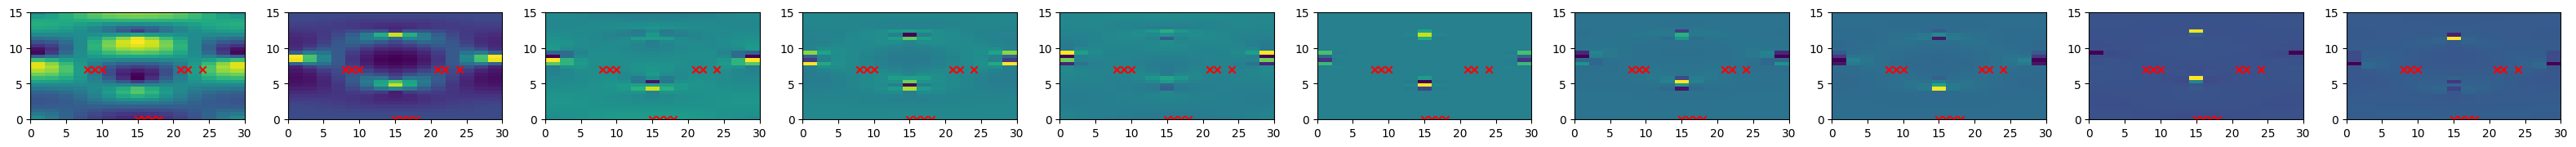

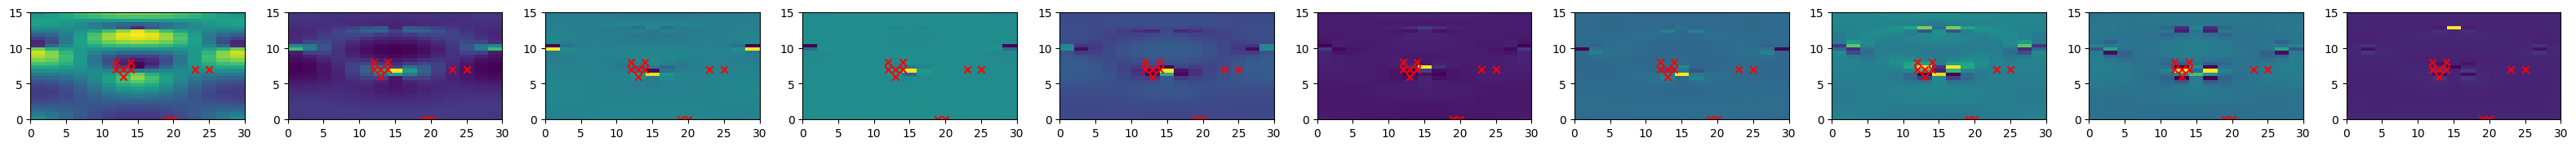

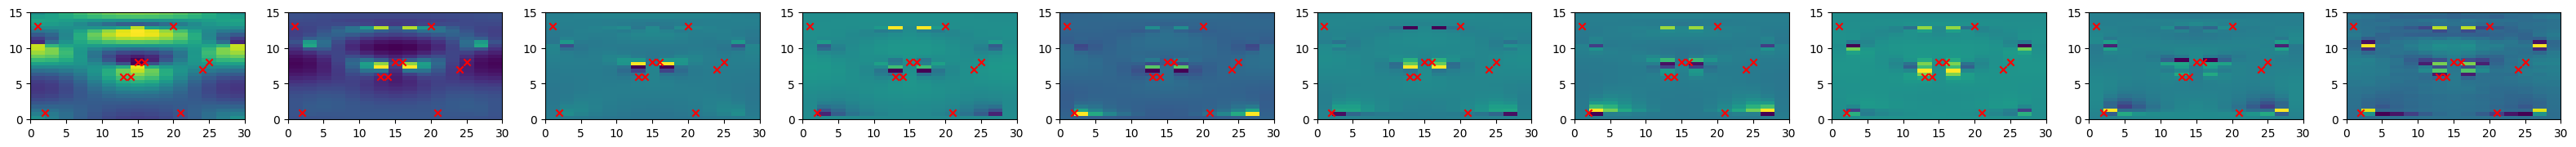

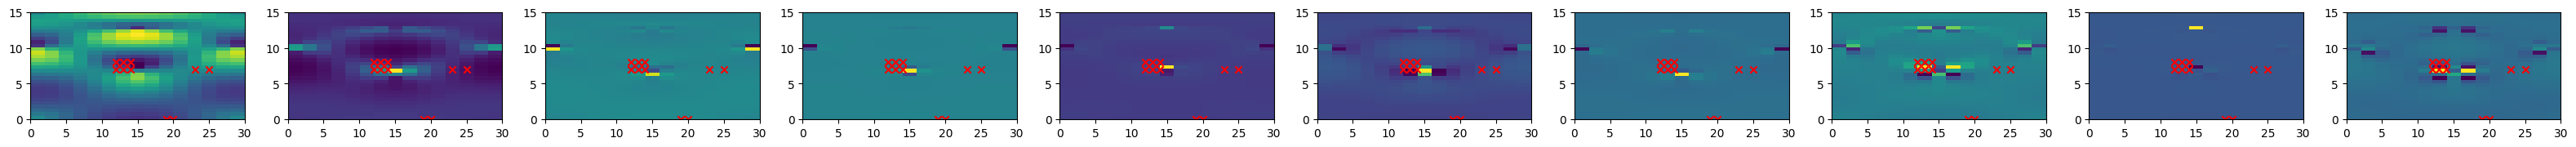

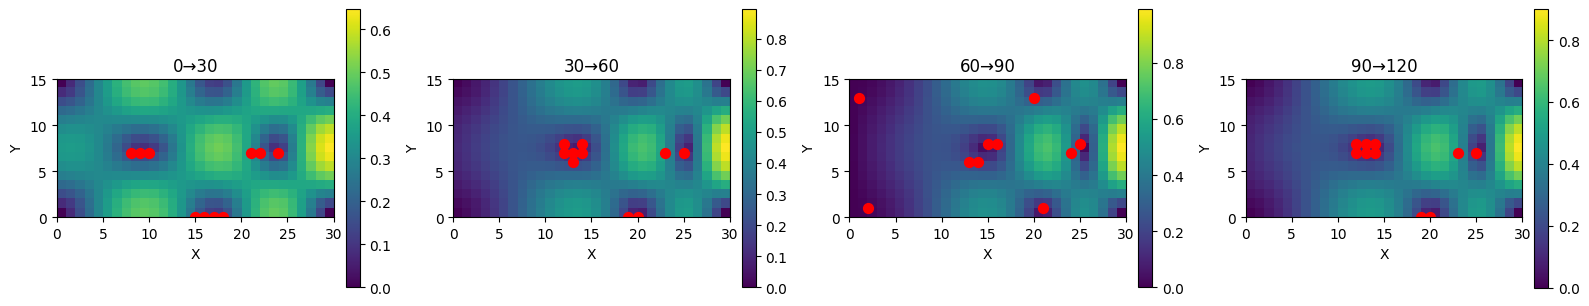

In [39]:
# Assuming interval_length, n_timesteps, n_basis_modes, n_sensors, magnitude, and ps are already defined

intervals = [
    (start, min(start + interval_length, n_timesteps))
    for start in range(0, n_timesteps, interval_length)
]

data = magnitude
_, nx_t, ny_t = data.shape
sensor_coords_list = []

for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]
    # Flatten and demean
    
    X = data_interval.reshape(interval_length, nx_t * ny_t).copy()
    X -= X.mean(axis=0)
    
    # Fit the POD+QR model
    basis = ps.basis.SVD(
        n_basis_modes=n_basis_modes,
        complex_mode=False,
        algorithm='arpack',
        random_state=90
    )
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)
    try:
        Phi = model.basis.basis_matrix  # shape: (nx_t*ny_t, n_basis_modes)
    except AttributeError:
        Phi = model.basis.components_
    
    Phi = Phi.T
    # Get sensor coordinates for overlay
    sensor_indices = model.selected_sensors
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T
    sensor_coords_list.append(sensor_coords)
    
    n = Phi.shape[1]
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    # Plot each mode as a 2D map
    for m in range(n):
        mode_map = Phi[:, m].reshape(nx_t, ny_t)
        axes[m].imshow(mode_map, origin='lower', extent=[0, nx_t, 0, ny_t])
        axes[m].scatter(sensor_coords[:,0], sensor_coords[:,1], c='r', marker='x', label='Sensors')
    plt.show()


# Optionally, plot sensor trajectories across all intervals
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)


## Velocity Reconstruction

In [47]:
# Feild representation
feild_representation = "complex" # ("complex", "concatenation")

if feild_representation == "concatenation":
    horizontal_concat = False
    data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
elif feild_representation == "complex":
    data = to_complex_cartesian(u_field, v_field) # (to_complex_cartesian, to_complex_polar)

_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

In [48]:
# Interval Params
sliding_intervals = True    # Boolean flag for sliding intervals
window_length, step_size = interval_length, 5    # Params for sliding window

if sliding_intervals:
    intervals = get_sliding_intervals(n_timesteps, window_length, step_size)
else:
    intervals = [
        (start, min(start + interval_length, n_timesteps))
        for start in range(0, n_timesteps, interval_length)
    ]

sensor_coords_list = []
for i, (start, end) in enumerate(intervals):
    data_interval = data[start:end]

    # flattens row-wise (but rmr row is a col-strip in our 2d map), so append on the slices of y-axis together
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    sensor_indices, _ = get_sspor_sensors(X, n_sensors, n_basis_modes, is_data_complex=(feild_representation == "complex"))
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T # get index in row-major form by default
    sensor_coords_list.append(sensor_coords)
    


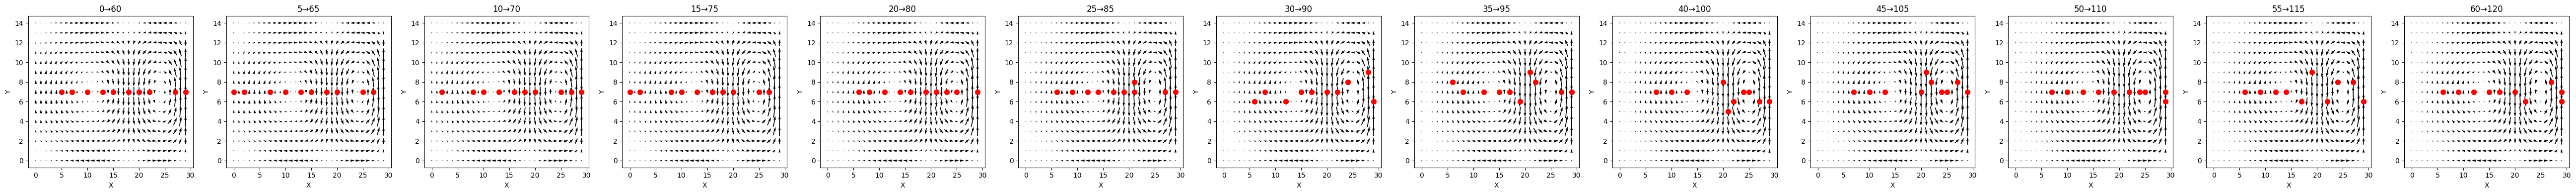

In [49]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

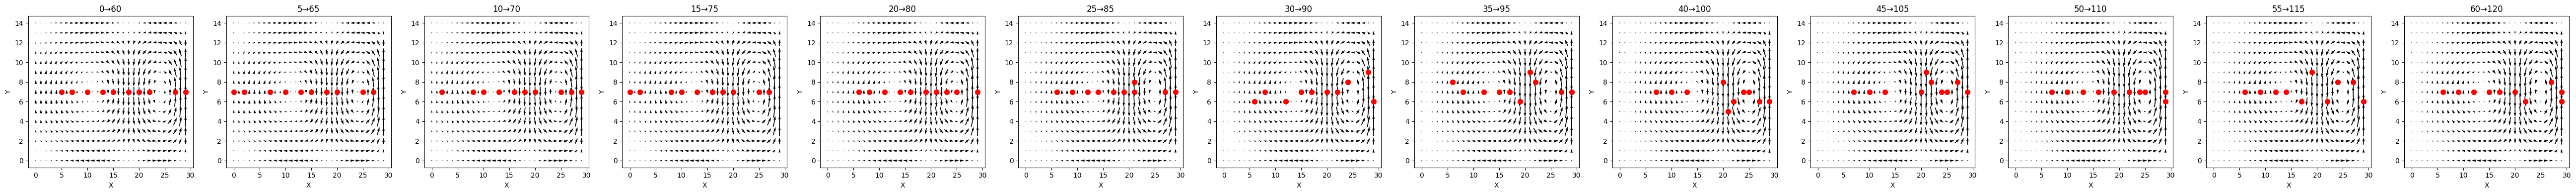

In [50]:
if feild_representation == "concatenation":
    sensor_coords_list = [map_sensor_to_original(sensor_coords, (nx_t, ny_t), horizontal_concat) for sensor_coords in sensor_coords_list]

plot_all_intervals((u_field, v_field), nx, ny, intervals, sensor_coords_list)

# Error Analysis

In [51]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [52]:
rows = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(u_field, v_field, horizontal_concat=horizontal_concat)
_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=True)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=True, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_measurements = X[:, sensor_idx]                
    X_pred = model.predict(Y_measurements)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Cart",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


   interval representation  Cartesian RMSE  Polar RMSE
0      0-60    Concat-Cart        0.181775    0.881794
1      5-65    Concat-Cart        0.190845    1.227455
2     10-70    Concat-Cart        0.198406    1.156258
3     15-75    Concat-Cart        0.187744    1.094650
4     20-80    Concat-Cart        0.156072    0.989144
5     25-85    Concat-Cart        0.148040    1.155315
6     30-90    Concat-Cart        0.122154    0.516643
7     35-95    Concat-Cart        0.091930    0.661579
8    40-100    Concat-Cart        0.186791    1.318570
9    45-105    Concat-Cart        0.222230    1.316834
10   50-110    Concat-Cart        0.185673    1.105848
11   55-115    Concat-Cart        0.229804    1.360124
12   60-120    Concat-Cart        0.189580    0.908115


In [53]:
rows   = []          # to build a DataFrame
horizontal_concat = True
data = combine_fields(magnitude, angle, horizontal_concat=horizontal_concat)

for interval_id, (start, end) in enumerate(intervals):
    data_interval = data[start:end] # augmented (T, nx_t, ny_t)
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    
    # fit + predict
    sensor_idx, _ = get_sspor_sensors(X, n_sensors, n_basis_modes,
                                    is_data_complex=False)
    model_basis = ps.basis.SVD(n_basis_modes=n_basis_modes,
                                complex_mode=False, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=model_basis)
    model.fit(X)
    
    # Measurements only at the selected sensor locations
    Y_measurements = X[:, sensor_idx]                
    X_pred = model.predict(Y_measurements)           
    X_pred = X_pred.astype(X.dtype)          
    
    #back to u,v
    u_true, v_true = split_state(X,      nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)
    u_pred, v_pred = split_state(X_pred, nx_t, ny_t,
                                    horizontal_concat=horizontal_concat)

    
    # polar fields
    r_true = np.sqrt(u_true**2 + v_true**2)
    r_pred = np.sqrt(u_pred**2 + v_pred**2)
    theta_true = np.arctan2(v_true, u_true)
    theta_pred = np.arctan2(v_pred, u_pred)
    
    #  RMSE metrics
    cart_err  = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))
    polar_err = 0.5 * (rmse(r_true, r_pred) + rmse(theta_true, theta_pred))
    
    rows.append({
        "interval"       : f"{start}-{end}",
        "representation" : f"{"Concat"}-Polar",   # complex snapshot built from u+iv
        "Cartesian RMSE" : cart_err,
        "Polar RMSE"     : polar_err
    })

err_df = pd.DataFrame(rows)
print(err_df)


   interval representation  Cartesian RMSE  Polar RMSE
0      0-60   Concat-Polar        0.659917    1.195232
1      5-65   Concat-Polar        0.627179    1.115906
2     10-70   Concat-Polar        0.642919    1.020784
3     15-75   Concat-Polar        0.459114    1.220704
4     20-80   Concat-Polar        0.454967    0.592854
5     25-85   Concat-Polar        0.420084    0.969368
6     30-90   Concat-Polar        0.280519    0.405740
7     35-95   Concat-Polar        0.522929    1.225261
8    40-100   Concat-Polar        0.546837    1.348553
9    45-105   Concat-Polar        0.305281    0.567353
10   50-110   Concat-Polar        0.682595    1.320154
11   55-115   Concat-Polar        0.514769    1.138406
12   60-120   Concat-Polar        0.346554    0.608094


# Optical Flow Feild

In [54]:
import cv2
import math
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

In [55]:
def sensors_to_gaussian_img(coords, nx, ny, sigma=1.3, amp=1.0):
    """
    coords : array (n_sensors,2)  -- integer grid indices (i,j)
    nx, ny : grid dimensions
    sigma  : std‑dev of Gaussian (in pixels)
    returns: 2‑D float image of shape (nx, ny)
    """
    img = np.zeros((nx, ny), dtype=np.float32)
    for i, j in coords:
        img[i, j] = amp                          # delta spike
    if sigma > 0:
        img = gaussian_filter(img, sigma=sigma)  # blur into blob
    # normalize so max=1 (helps optical flow)
    img /= img.max() + 1e-9
    return img

In [ ]:
def get_farneback_hyperparams(nx, ny,        # grid resolution   (pixels)
                        lx, ly,        # domain size       (same units as velocity)
                        dt,            # time‑step between frames
                        u_max,         # estimate of max |u| in domain units/sec
                        blob_sigma_px, # Gaussian blur sigma used for each sensor (pixels)
                        pyr_scale=0.5  # keep 0.5 
                       ):
    """
    Compute a reasonable Farnebäck parameter dictionary.
    Returns something you can splat straight into calcOpticalFlowFarneback(**params).
    """
    # convert physics to pixel displacements per frame 
    dx = lx / nx  # one pixel in physical units
    disp_px = u_max * dt / dx # max jump in *pixels* per frame

    # pick pyramid depth so residual motion <= 3 px at coarsest
    if disp_px <= 3:
        levels = 1
        residual = disp_px
    else:
        levels = math.ceil(1 + math.log(disp_px / 3, 1 / pyr_scale))
        residual = disp_px * (pyr_scale ** (levels - 1))

    # needs to cover both the blob diameter (≈ 4 sigma) and the residual jump
    winsize = int(2 * max(blob_sigma_px * 2, residual))
    if winsize % 2 == 0: # Farnebäck prefers odd windows
        winsize += 1

    poly_n = 5 if max(nx, ny) < 1000 else 7
    poly_sigma = 1.1 if poly_n == 5 else 1.5

    return dict(pyr_scale=pyr_scale,
                levels=levels,
                winsize=winsize,
                iterations=3,  
                poly_n=poly_n,
                poly_sigma=poly_sigma,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [ ]:
def compute_blob_sigma(sensor_coords_list,
                        target_amp=0.3,
                        mode="max"):
    """
    Compute blob sigma so that across ALL timesteps your Gaussian blobs
    overlap at `target_amp` of peak.

    sensor_coords_list : list of (n_sensors,2) arrays or lists of (x,y) tuples
    target_amp         : desired amplitude at neighbor center (0<target_amp<1)
    mode               : "mean" (avg spacing) or "max" (worst-case spacing)
    """
    all_nn_dist = []

    for coords in sensor_coords_list:
        # ensure an (N,2) array of floats
        arr = np.array(coords, dtype=float)
        if arr.ndim != 2 or arr.shape[1] != 2:
            raise ValueError("Each coords entry must be shape (n,2)")

        # build KD-tree & find 2nd neighbor (first is self at zero)
        tree = cKDTree(arr)
        dists, _ = tree.query(arr, k=2)
        nn = dists[:,1] 
        all_nn_dist.append(nn)

    all_nn_dist = np.concatenate(all_nn_dist)

    if mode == "mean":
        d_ref = all_nn_dist.mean()
    elif mode == "max":
        d_ref = all_nn_dist.max()
    else:
        raise ValueError("mode must be 'mean' or 'max'")

    sigma_px = d_ref / math.sqrt(2 * math.log(1/target_amp))
    return sigma_px


In [58]:
compute_blob_sigma(sensor_coords_list)

3.866588135745217

In [59]:
# setting hyper_params
blob_sigma_px = compute_blob_sigma(sensor_coords_list)

frames = [sensors_to_gaussian_img(coord_set, nx, ny, sigma=blob_sigma_px)
          for coord_set in sensor_coords_list]   
frames = np.stack(frames, axis=0)

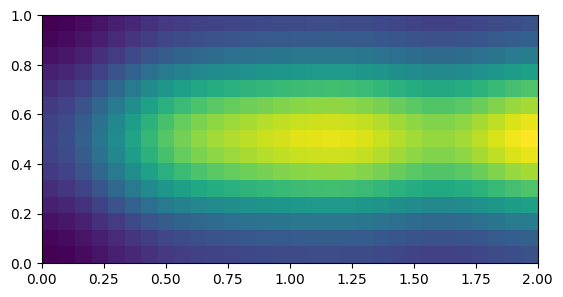

In [60]:
plt.imshow(frames[0].T, origin='lower', extent=[0, lx, 0, ly], cmap='viridis')

In [61]:
dt = period / n_timesteps
u_max = data.max()                    
fb_params = get_farneback_hyperparams(nx, ny, lx, ly, dt,
                                u_max, blob_sigma_px)

In [62]:
flows = []  # will hold (flow_x, flow_y) arrays of shape (nx, ny)
for k in range(len(frames) - 1):
    f0 = frames[k].astype(np.float32)
    f1 = frames[k + 1].astype(np.float32)
    flow = cv2.calcOpticalFlowFarneback(
        prev=f0.T, next=f1.T,   # transpose: OpenCV uses (rows,cols) = (y,x)
        flow=None,
        **fb_params)
    # flow has shape (ny, nx, 2): (vx, vy) in pixel units
    flow = flow.transpose(1, 0, 2)   # back to (nx, ny, 2)
    flows.append(flow)

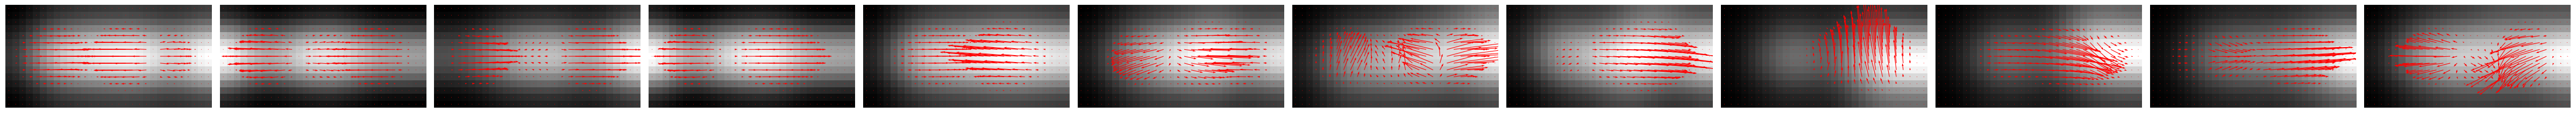

In [63]:
fig, axes = plt.subplots(1, len(flows), figsize=(4*len(flows),4))
for ax, img, flow in zip(axes, frames[:-1], flows):
    ax.imshow(img.T, origin='lower', cmap='gray')
    skip = 1      # thin quiver for clarity
    X, Y = np.meshgrid(np.arange(0, nx, skip), np.arange(0, ny, skip), indexing='ij')
    U = flow[::skip, ::skip, 0];  V = flow[::skip, ::skip, 1]
    ax.quiver(X, Y, U, V, color='red')
    ax.set_axis_off()
plt.tight_layout(); plt.show()

# Guidance Feild

In [16]:
def build_guidance_field(nx, ny, lx, ly, qr_targets):
    """
    Return u(x,y), v(x,y) arrays whose vectors point toward
    the nearest POD–QR target.
    """
    grid_x = np.linspace(0, lx, nx)
    grid_y = np.linspace(0, ly, ny)

    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij') # shape (nx,ny)
    pos = np.stack([X[..., None], Y[..., None]], axis=-1) # (nx,ny,1,2)

    # qr_targets: array (m,2)
    diff = qr_targets[None, None, :, :] - pos  # (nx,ny,m,2)
    dist2 = np.sum(diff**2, axis=-1)  # (nx,ny,m)

    jstar = np.argmin(dist2, axis=-1)  # nearest target idx
    v = diff[np.arange(diff.shape[0])[:, None],      
             np.arange(diff.shape[1])[None, :,],
             jstar] # (nx,ny,2)

    # cap speed: 20 % of domain per dt
    vmax = 0.2 * lx          
    speed = np.linalg.norm(v, axis=-1, keepdims=True)
    v = v / np.maximum(1, speed/vmax)

    u_field = v[..., 0]
    v_field = v[..., 1]
    return u_field, v_field

In [14]:
def grid_to_phys(coords, nx, ny, lx, ly):
    """
    Transform sensor positions from grid indices (i,j) to physical (x,y) coordinates.
    coords : array_like, shape (m,2)
        Integer grid indices [[i1,j1], [i2,j2], ...].

    Returns
    phys_coords : ndarray, shape (m,2)
        Physical coordinates corresponding to each grid index.
    """
    grid_x = np.linspace(0, lx, nx)
    grid_y = np.linspace(0, ly, ny)
    coords = np.asarray(coords, dtype=int)
    i_idx, j_idx = coords[:,0], coords[:,1]
    x_phys = grid_x[i_idx]
    y_phys = grid_y[j_idx]
    return np.column_stack([x_phys, y_phys])

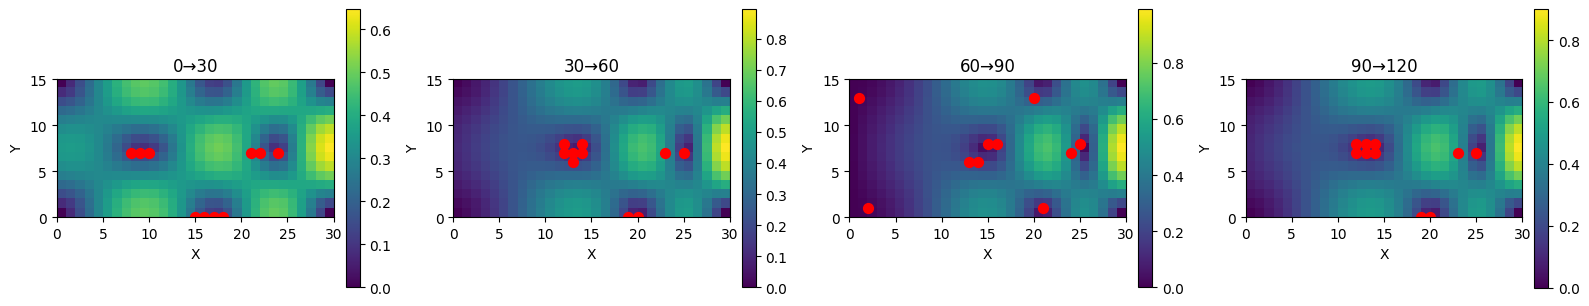

In [167]:
plot_all_intervals(data, nx_t, ny_t, intervals, sensor_coords_list)

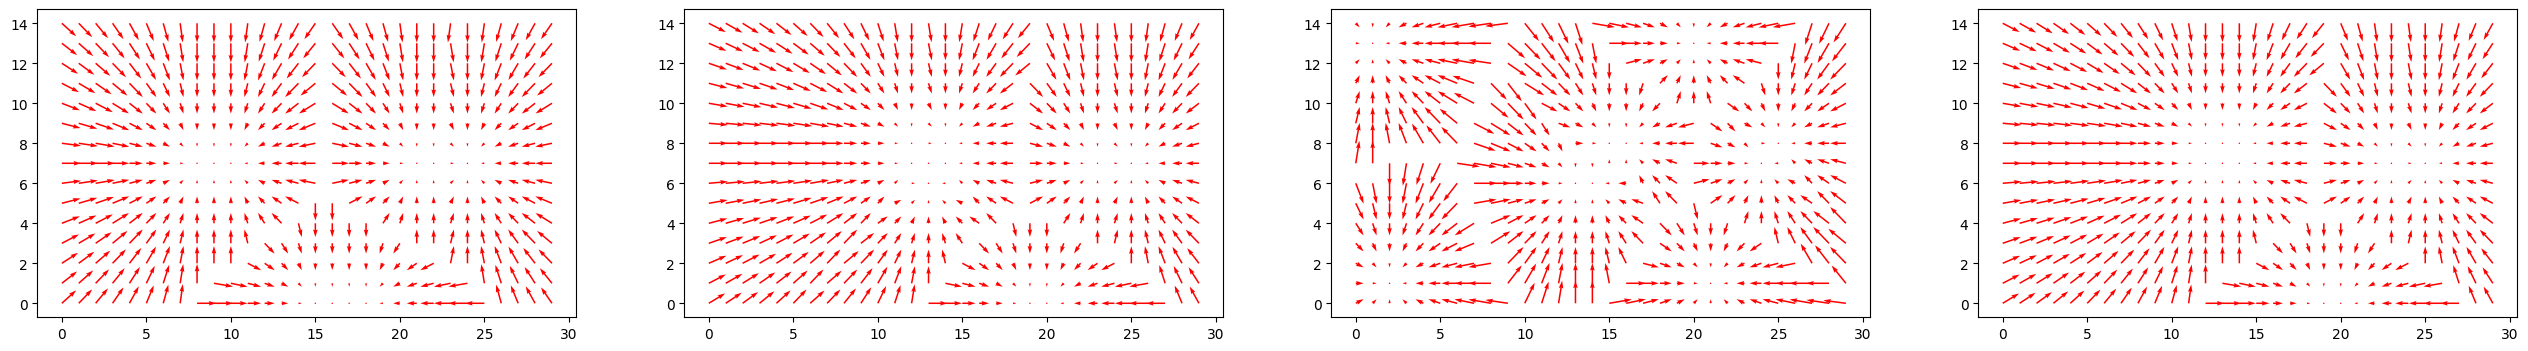

In [180]:
fig, axes = plt.subplots(1, len(sensor_coords_list), 
                         figsize=(8*len(sensor_coords_list),4))

for sensor_coords, ax in zip(sensor_coords_list, axes):
    u_g, v_g = build_guidance_field(nx_t, ny_t, lx, ly, 
                     grid_to_phys(sensor_coords, nx_t, ny_t, lx, ly))
    skip = 1      # thin quiver for clarity
    X, Y = np.meshgrid(np.arange(0, nx, skip), np.arange(0, ny, skip), indexing='ij')
    U = u_g[::skip, ::skip];  V = v_g[::skip, ::skip]
    ax.quiver(X, Y, U, V, color='red')
    # ax.set_aspect(ly / lx)    


# Sensor Movement Comparison

In [28]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
import pysensors as ps

In [29]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [30]:
SEED = 42
rng = np.random.default_rng(SEED)

TOTAL_STEPS = 120
NX, NY = 30, 15
LX, LY = 2.0, 1.0
PERIOD = 300

num_sensors = 12
WINDOW_LEN = 30
MAX_BASIS_DIM = 12
num_cv_folds = 3

In [31]:
def linspace_interior(length, n, pad_frac=0.05):
    return np.linspace(pad_frac * length, (1 - pad_frac) * length, n)


def seed_sensor_grid(n, Lx, Ly):
    gx = int(np.sqrt(n * Lx / Ly))
    gy = int(np.ceil(n / gx))
    xs, ys = linspace_interior(Lx, gx), linspace_interior(Ly, gy)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    return np.column_stack([xv.ravel(), yv.ravel()])[:n]


def advect(points, u, v,
           Lx, Ly, dt=1.0):
    grid_x = np.linspace(0, Lx, NX)
    grid_y = np.linspace(0, LY, NY)
    Ui = RegularGridInterpolator((grid_x, grid_y), u)
    Vi = RegularGridInterpolator((grid_x, grid_y), v)
    vel = np.stack([Ui(points), Vi(points)], axis=1)
    pts_new = points + dt * vel
    pts_new[:, 0] = np.clip(pts_new[:, 0], 0.0, Lx)
    pts_new[:, 1] = np.clip(pts_new[:, 1], 0.0, Ly)
    return pts_new


def coords_to_linear_index(points, nx, ny,
                           Lx, Ly):
    i = np.clip(np.round(points[:, 0] / Lx * (nx - 1)).astype(int), 0, nx - 1)
    j = np.clip(np.round(points[:, 1] / Ly * (ny - 1)).astype(int), 0, ny - 1)
    return np.ravel_multi_index((i, j), (nx, ny))

In [32]:
def fourier_basis(nx, ny, kx, ky, cap=MAX_BASIS_DIM):
    """kx is the number of (sin, cos) pair in x direction; similar with ky"""
    xs, ys = np.linspace(0, 1, nx, endpoint=False), np.linspace(
        0, 1, ny, endpoint=False)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    g = np.column_stack([xv.ravel(), yv.ravel()])
    cols = [np.ones(nx*ny)]
    for m in range(1, kx+1):
        cols += [np.cos(2*np.pi*m*g[:, 0]), np.sin(2*np.pi*m*g[:, 0])]
    for n in range(1, ky+1):
        cols += [np.cos(2*np.pi*n*g[:, 1]), np.sin(2*np.pi*n*g[:, 1])]
    return np.column_stack(cols)[:, :cap]

import numpy as np

def fourier2d_basis(nx, ny, kx, ky, cap=MAX_BASIS_DIM, order="radial"):
    """
    Build a full 2‑D Fourier dictionary on [0,1]^2.

    Parameters
    ----------
    nx, ny : int
        Number of grid points in x and y.
    kx, ky : int
        Maximum integer frequencies |m| ≤ kx and |n| ≤ ky (inclusive).
    cap : int or None, optional
        If not None, keep only the first `cap` columns.
    order : {"radial", "lex"}, optional
        * "radial": sort modes by increasing sqrt(m**2 + n**2).
        * "lex":    (m,n) nested loops, standard lexicographic order.

    Returns
    -------
    Phi : ndarray, shape (nx*ny, num_modes)
        Flattened design matrix whose columns are
        [1, cos(2π(mx+ny)), sin(2π(mx+ny)), ...].
    mode_indices : list[tuple]
        List of (kind, m, n) triples: kind ∈ {"1", "c", "s"}.
        Useful for inspecting which column is which.
    """
    # grid coordinates (periodic [0,1) so endpoint=False)
    xs = np.linspace(0, 1, nx, endpoint=False)
    ys = np.linspace(0, 1, ny, endpoint=False)
    xv, yv = np.meshgrid(xs, ys, indexing="ij") # shape (nx, ny)
    grid  = np.column_stack([xv.ravel(), yv.ravel()]) # (nx*ny, 2)

    cols, meta = [], []  # design matrix + bookkeeping
    cols.append(np.ones(nx * ny)) # constant mode
    meta.append(("1", 0, 0))

    # generate all (m,n) pairs (skip (0,0))
    pairs = [(m, n)
             for m in range(-kx, kx + 1)
             for n in range(-ky, ky + 1)
             if not (m == 0 and n == 0)]

    if order == "radial": # sort by Euclidean magnitude, then lex
        pairs.sort(key=lambda mn: (mn[0] ** 2 + mn[1] ** 2, mn[0], mn[1]))
    else: # "lex": keep generator order
        pairs.sort(key=lambda mn: (mn[0], mn[1]))

    # build cos / sin columns
    for m, n in pairs:
        phase = 2 * np.pi * (m * grid[:, 0] + n * grid[:, 1])
        cols.append(np.cos(phase))
        meta.append(("c", m, n))
        cols.append(np.sin(phase))
        meta.append(("s", m, n))

        if cap is not None and len(cols) >= cap:
            break

    Phi = np.column_stack(cols)[:, :cap] if cap else np.column_stack(cols)
    meta = meta[:Phi.shape[1]]
    return Phi, meta



def polynomial_basis(nx, ny, deg, cap=MAX_BASIS_DIM):
    xs, ys = np.linspace(-1, 1, nx), np.linspace(-1, 1, ny)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    phi_full = PolynomialFeatures(degree=deg, include_bias=True).fit_transform(
        np.column_stack([xv.ravel(), yv.ravel()]))
    return phi_full[:, :cap]


def rbf_basis(nx, ny, sigma, cap=MAX_BASIS_DIM):
    xs, ys = np.linspace(0, 1, nx), np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(xs, ys, indexing="ij")
    grid = np.column_stack([xv.ravel(), yv.ravel()])
    rng = np.random.default_rng(SEED)
    centres = rng.uniform(0, 1, size=(cap, 2))
    dist2 = np.sum((grid[:, None, :]-centres[None, :, :])**2, axis=2)
    return np.exp(-dist2/(2*sigma**2))

In [33]:
from sklearn.model_selection import TimeSeriesSplit

def cv_rmse(basis,
            Y_u,
            Y_v,
            sensor_index,
            num_cv_folds=1):
    """
    Cross-validated RMSE for a candidate basis phi.

    If num_cv_folds == 1, returns the RMSE on the full dataset
    (no cross-validation).

    Parameters
    ----------
    basis : (N, m) array
        Columns are m basis functions sampled on the grid.
    Y_u, Y_v : (T, p) arrays
        Measured u, v at the p chosen sensors for T snapshots.
    sensor_index : (p,) int array
        Indices of the p sensors in row-major grid ordering.
    num_cv_folds : int, default 4
        Number of time-series CV splits; if 1, evaluate on full data.
    """
    C = np.eye(basis.shape[0])[sensor_index]
    pinv = np.linalg.pinv(C @ basis)

    def _rmse_on(idx):
        a_u = Y_u[idx] @ pinv.T
        a_v = Y_v[idx] @ pinv.T
        X_u_hat = a_u @ basis.T
        X_v_hat = a_v @ basis.T
        return 0.5 * np.sqrt(
            np.mean((Y_u[idx] - X_u_hat[:, sensor_index])**2) +
            np.mean((Y_v[idx] - X_v_hat[:, sensor_index])**2)
        )

    # If only one fold, evaluate on the full dataset
    if num_cv_folds <= 1:
        idx_all = np.arange(Y_u.shape[0])
        return float(_rmse_on(idx_all))

    # Otherwise do time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=num_cv_folds)
    errs = []
    for _, test_idx in tscv.split(Y_u):
        errs.append(_rmse_on(test_idx))

    return float(np.mean(errs))


In [40]:
def tune_pod(u_interval, v_interval, n_modes=MAX_BASIS_DIM, seed=SEED):
    """
    Compute a POD basis (separately for u and v) on the current window.
    """
    pod_u = ps.basis.SVD(n_basis_modes=n_modes,
                         complex_mode=False,
                         algorithm="arpack",
                         random_state=seed)
    pod_u.fit(u_interval)

    pod_v = ps.basis.SVD(n_basis_modes=n_modes,
                         complex_mode=False,
                         algorithm="arpack",
                         random_state=seed)
    pod_v.fit(v_interval)

    phi_u = pod_u.basis_matrix_
    phi_v = pod_v.basis_matrix_
    return phi_u, phi_v


def tune_fourier(nx, ny, sensor_index, Yu, Yv):
    # full range of wavenumbers you could possibly use -- using nyquist thm
    max_kx = nx // 2
    max_ky = ny // 2

    all_pairs = [(kx, ky)
                 for kx in range(1, max_kx + 1)
                 for ky in range(1, max_ky + 1)]

    # sort them by total frequency (asc)
    all_pairs.sort(key=lambda t: (t[0] + t[1], t[0], t[1]))

    # pick 10 evenly spaced indices from that sorted list
    n_candidates = len(all_pairs)
    step = max(1, n_candidates // 10)
    selected_pairs = [all_pairs[i] for i in range(0, n_candidates, step)][:10]

    best = None
    for kx, ky in selected_pairs:
        phi, _ = fourier2d_basis(nx, ny, kx, ky)
        err = cv_rmse(phi, Yu, Yv, sensor_index)
        tag = f"Fourier({kx},{ky})"
        if best is None or err < best[0]:
            best = (err, phi, tag)

    return best[1], best[2]


def tune_poly(nx, ny, sensor_index, Yu, Yv, cap=MAX_BASIS_DIM):
    # Compute max polynomial degree; theres at most (d+2)C2
    max_terms = min(cap, nx*ny)
    d_max = min(int(np.floor((np.sqrt(8*max_terms + 1) - 3) / 2)), 5)
    degs = np.unique(np.linspace(1, d_max, num=min(d_max, 10), dtype=int))

    candidates = []
    for d in degs:
        phi = polynomial_basis(nx, ny, d, cap=cap)
        err = cv_rmse(phi, Yu, Yv, sensor_index)
        candidates.append((err, phi, f"Poly deg={d}"))

    return min(candidates, key=lambda t: t[0])[1:]


def tune_rbf(nx, ny, sensor_index, Yu, Yv):
    cand = []
    for sigma in [0.05, 0.1, 0.15, 0.25]:
        phi = rbf_basis(nx, ny, sigma)
        cand.append((cv_rmse(phi, Yu, Yv, sensor_index),
                    phi, f"RBF sigma={sigma}"))
    return min(cand, key=lambda t: t[0])[1:]

In [41]:
def bounce_apart(coords, min_dist, lx, ly):
    """
    If any two probes are closer than min_dist, push them straight
    away from each other just enough to meet min_dist.
    """
    p = len(coords)
    for i in range(p):
        for j in range(i+1, p):
            dx = coords[i,0] - coords[j,0]
            dy = coords[i,1] - coords[j,1]

            # shortest periodic displacement
            dx = (dx + lx/2) % lx - lx/2
            dy = (dy + ly/2) % ly - ly/2
            dist = np.hypot(dx, dy)

            if dist < 1e-12: # exactly same point – random nudge
                dx, dy, dist = 1e-6, 0, 1e-6

            if dist < min_dist:
                overlap = 0.5 * (min_dist - dist)
                # normalised direction
                ux, uy = dx/dist, dy/dist
                # move i one way, j the opposite
                coords[i,0] +=  overlap*ux
                coords[i,1] +=  overlap*uy
                coords[j,0] -=  overlap*ux
                coords[j,1] -=  overlap*uy

    # wrap back into periodic domain
    coords[:,0] %= lx
    coords[:,1] %= ly
    return coords


In [108]:
num_sensors = 12
WINDOW_LEN = 30
MAX_BASIS_DIM = 12
num_cv_folds = 3

TOTAL_STEPS = 300
PERIOD = 300

# # double gyre
NX, NY = 30, 15
LX, LY = 2.0, 1.0
u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
                                A=0.1, epsilon=0.5, period=PERIOD)

# # moving vortex
# NX, NY = 25, 25 # number of grid points along each axis
# LX, LY = 1, 1 # changeable
# u, v = generate_moving_vortex(TOTAL_STEPS, NX,NY, LX,LY, period=PERIOD)

In [109]:
import random


In [ ]:
def run_experiment():
    # generate velocity snapshots
    # u, v = generate_double_gyre_flow(TOTAL_STEPS, NX, NY, LX, LY,
    #                                  A=0.1, epsilon=0.5, period=PERIOD)
    # u, v = generate_moving_vortex()

    u_flattened = u.reshape(TOTAL_STEPS, -1)
    v_flattened = v.reshape(TOTAL_STEPS, -1)
    grid_N = u_flattened.shape[1]


    windows = [(s, min(s + WINDOW_LEN, TOTAL_STEPS))
               for s in range(0, TOTAL_STEPS, WINDOW_LEN)]

    lagrangian_sensor_location = seed_sensor_grid(num_sensors, LX, LY)
    guided_sensor_location = lagrangian_sensor_location.copy()


    records = []

    n = TOTAL_STEPS // WINDOW_LEN
    fig, axes = plt.subplots(1, n, figsize=(8*n, 4))

    for window_index, (start_index, end_index) in enumerate(tqdm(windows, desc="windows")):
        Xu, Xv = u_flattened[start_index: end_index], v_flattened[start_index:end_index]

        # Concatenate the u and v snapshots
        uv_concatenated = np.concatenate([Xu, Xv], axis=1)
        basis = ps.basis.SVD(n_basis_modes=MAX_BASIS_DIM,
                             complex_mode=False,
                             algorithm="arpack",
                             random_state=SEED)

        model = ps.SSPOR(n_sensors=num_sensors, basis=basis)
        model.fit(uv_concatenated)

        # adding a bit of random noise to grid point
        # new_sensors = [idx + (5 * random.choice([-1, 1])) for idx in model.selected_sensors]
        new_sensors = model.selected_sensors
        # print("QR-true: ", new_sensors)

        Y_measurements = uv_concatenated[:,new_sensors]
        # Option A
        C = np.eye(grid_N*2)[new_sensors]
        pinv = np.linalg.pinv(C @ model.basis_matrix_)
        concatenated_prediction = (Y_measurements @ pinv.T) @ model.basis_matrix_.T

        # # Option B
        # concatenated_prediction = model.predict(Y_measurements)


        # split the concatenated states back into u and v grids
        u_true, v_true = Xu, Xv
        u_pred, v_pred = np.split(concatenated_prediction, 2, axis=1)
        rmse_sspor = 0.5 * (rmse(u_true, u_pred) + rmse(v_true, v_pred))

        records.append(
            dict(window=window_index, placement="QR",
                 basis="POD", RMSE=rmse_sspor)
        )

        # Build SSPOR Guidance feild
        qr_indices = model.selected_sensors
        qr_grid_idx = np.mod(qr_indices, grid_N)
        ij = np.column_stack(np.unravel_index(qr_grid_idx, (NX, NY)))
        qr_phys = grid_to_phys(ij, NX, NY, LX, LY)
        u_g, v_g = build_guidance_field(NX, NY, LX, LY, qr_phys)

        # Eulerian sensors computed only first window
        if window_index == 0:
            eulerian_sensor_indicies = coords_to_linear_index(
                lagrangian_sensor_location, NX, NY, LX, LY)

        lagrangian_sensor_indicies = coords_to_linear_index(
            lagrangian_sensor_location, NX, NY, LX, LY)

        guidance_sensor_indicies = coords_to_linear_index(
            guided_sensor_location, NX, NY, LX, LY)
        # print("guidance: ", guidance_sensor_indicies)

        if True:  # for plotting sensors
            x = np.linspace(0, LX, NX)
            y = np.linspace(0, LY, NY)

            Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

            axes[window_index].quiver(Xgrid, Ygrid, u_g, v_g, color='black',
                                      scale_units='xy', scale=10, width=0.005, pivot='mid')

            axes[window_index].scatter(guided_sensor_location[:,0], guided_sensor_location[:,1],
                                       color='blue', s=50, marker='o', label='selected')
            
            axes[window_index].scatter(qr_phys[:,0], qr_phys[:,1],
                            color='red', s=50, marker='o', label='selected')
            # plt.show()

        # evaluate other bundles
        bundle_dict = {
            "Euler":  eulerian_sensor_indicies,
            "Lag": coords_to_linear_index(lagrangian_sensor_location,
                                          NX, NY, LX, LY),
            "SSPOR Guidance": coords_to_linear_index(guided_sensor_location,
                                                     NX, NY, LX, LY)
        }

        for label, sensor_index in bundle_dict.items():
            Yu, Yv = Xu[:, sensor_index], Xv[:, sensor_index]
            # auto‑tune bases for this sensor set
            phi_fourier, _ = tune_fourier(NX, NY, sensor_index, Yu, Yv)
            phi_poly, _ = tune_poly(NX, NY, sensor_index, Yu, Yv)
            phi_rbf,  _ = tune_rbf(NX, NY, sensor_index, Yu, Yv)
            phi_pod_u, phi_pod_v = tune_pod(Xu, Xv)
            for tag, (phi_u, phi_v) in {
                'Fourier': (phi_fourier, phi_fourier),
                'Polynomal': (phi_poly, phi_poly),
                'RBF': (phi_rbf,  phi_rbf),
                'POD': (phi_pod_u,  phi_pod_v)
            }.items():
                # LS reconstruction component‑wise
                C = np.eye(grid_N)[sensor_index]
                pinv_u = np.linalg.pinv(C @ phi_u)
                pinv_v = np.linalg.pinv(C @ phi_v)
                X_hat_u = (Yu @ pinv_u.T) @ phi_u.T
                X_hat_v = (Yv @ pinv_v.T) @ phi_v.T

                rmse_uv = 0.5 * (rmse(Xu, X_hat_u) +
                                 rmse(Xv, X_hat_v))

                records.append(
                    dict(window=window_index,
                         placement=label,
                         basis=tag,
                         RMSE=float(rmse_uv))
                )

        # Move lagrangian and guided probes
        # Passive Lagrangian probes – follow flow
        lagrangian_sensor_location = advect(lagrangian_sensor_location,
                                            u[end_index-1], v[end_index-1],
                                            LX, LY, dt=1.0)
        lagrangian_sensor_location[:, 0] %= LX
        lagrangian_sensor_location[:, 1] %= LY

        # SSPOR‑Guided probes – follow guidance field
        guided_sensor_location = advect(guided_sensor_location,
                                        u_g, v_g,
                                        LX, LY, dt=1.0)
        guided_sensor_location[:, 0] %= LX
        guided_sensor_location[:, 1] %= LY

        # ensure sensors don't overlap
        # after moving Lagrangian probes
        min_dist_percentage = 0.05
        lagrangian_sensor_location = bounce_apart(
            lagrangian_sensor_location, min_dist=min_dist_percentage*LX, lx=LX, ly=LY)

        # after moving SSPOR‑Guided probes
        guided_sensor_location = bounce_apart(
            guided_sensor_location, min_dist=min_dist_percentage*LX, lx=LX, ly=LY)

        # print(lag_pts)


    results = pd.DataFrame(records)

    # quick bar‑plot of mean RMSE per bundle
    means = (
        results
        .groupby(["placement", "basis"])
        .RMSE.mean()
        .sort_values()
    )
    print(means)
    plt.figure(figsize=(8, 4))
    means.plot(kind="barh", logx=True)
    plt.xlabel("mean RMSE")
    plt.tight_layout()
    plt.show()

windows:  10%|█         | 1/10 [00:01<00:17,  1.99s/it]

[0.1 0.1 0.1 0.7 0.7 0.7 1.3 1.3 1.3 1.9 1.9 1.9] [0.05 0.5  0.95 0.05 0.5  0.95 0.05 0.5  0.95 0.05 0.5  0.95]


windows:  20%|██        | 2/10 [00:02<00:09,  1.22s/it]

[0.06850534 0.05342613 0.0778909  0.6914569  0.68651925 0.69341452
 1.3085431  1.31348075 1.30658548 1.85851586 1.94198114 1.98212013] [0.42389033 0.48821472 0.58794654 0.42466315 0.48778743 0.58754942
 0.42466315 0.48778743 0.58754942 0.41627343 0.46984064 0.56143137]


windows:  30%|███       | 3/10 [00:03<00:06,  1.03it/s]

[0.08749988 1.89252683 0.05442135 0.70267998 0.53803611 0.63803611
 1.37570689 1.30017024 1.2113708  1.85536065 1.95476198 1.96495047] [0.5        0.52203332 0.52642174 0.5        0.5        0.5
 0.43043751 0.4695547  0.51554012 0.42439665 0.41543391 0.51491353]


windows:  40%|████      | 4/10 [00:04<00:05,  1.14it/s]

[0.0499995  1.84375588 1.87528933 0.70135226 0.5526329  0.64715823
 1.47792668 1.37792668 1.1893649  1.80569769 0.04105605 1.94105605] [0.5        0.5        0.5        0.4721522  0.52349579 0.49086204
 0.5        0.5        0.5175565  0.5        0.5        0.5       ]


windows:  50%|█████     | 5/10 [00:04<00:04,  1.19it/s]

[0.08802716 1.87710864 0.05783148 0.75862069 0.541427   0.641427
 1.4575775  1.3575775  1.24137931 1.71814362 1.89273364 1.99273364] [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


windows:  60%|██████    | 6/10 [00:05<00:03,  1.16it/s]

[0.07726446 1.89466646 1.93186405 0.73965467 0.54568991 0.64568991
 1.51724138 1.37931034 1.17241379 1.65517241 1.81206947 0.03186405] [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.42857143 0.5        0.5        0.5       ]


windows:  70%|███████   | 7/10 [00:06<00:02,  1.04it/s]

[0.09478737 1.89946842 0.08045263 0.75905514 0.48275862 0.6702557
 1.4637931  1.3637931  1.10344828 1.5862069  1.92094473 0.02094473] [0.5        0.5        0.5        0.50022498 0.5        0.45423956
 0.5        0.5        0.42857143 0.5        0.5        0.5       ]


windows:  80%|████████  | 8/10 [00:08<00:02,  1.00s/it]

[0.09984951 1.909252   0.0936921  0.82758621 0.48275862 0.62068966
 1.44482759 1.34482759 1.10344828 1.5862069  1.93591216 0.03591216] [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


windows:  90%|█████████ | 9/10 [00:08<00:00,  1.13it/s]

[0.10597534 1.98740205 0.01664687 0.82758621 0.48275862 0.68965517
 1.45431009 1.29181047 1.03448276 1.39181047 0.02233826 1.97885863] [0.42015071 0.55788878 0.36049448 0.42857143 0.42857143 0.42857143
 0.42857143 0.42857143 0.5        0.42857143 0.5186166  0.42856371]


windows: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

[0.09837623 1.90844057 0.09391086 0.82758621 0.48275862 0.62068966
 1.39137906 1.23189618 1.03448276 1.33189618 1.936646   0.036646  ] [0.5        0.5        0.5        0.57142857 0.5        0.42857143
 0.5        0.5        0.5        0.5        0.5        0.5       ]
placement       basis    
QR              POD          3.237642e-16
Euler           POD          7.002052e-02
SSPOR Guidance  POD          7.696635e-02
Lag             POD          8.772508e-02
Euler           Polynomal    1.064339e-01
                Fourier      1.125991e-01
Lag             Fourier      2.122815e-01
                Polynomal    3.316035e-01
SSPOR Guidance  Fourier      5.088710e-01
                Polynomal    1.307625e+00
Euler           RBF          4.011075e+00
Lag             RBF          3.182347e+02
SSPOR Guidance  RBF          1.972155e+03
Name: RMSE, dtype: float64


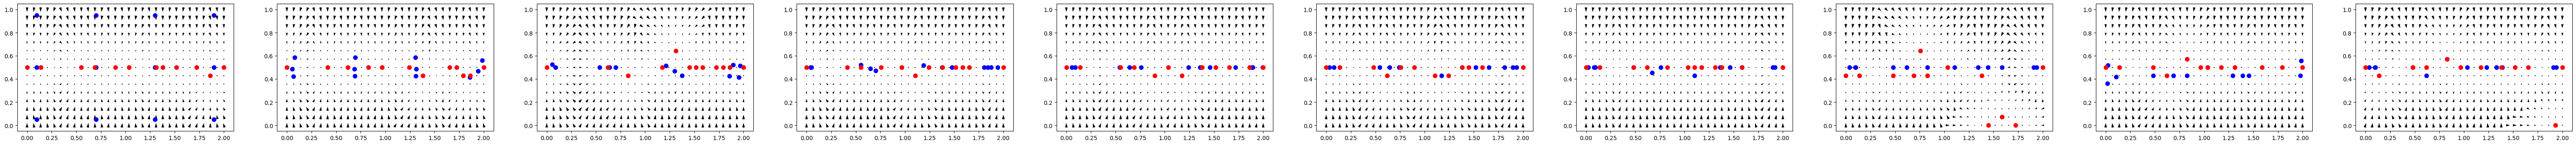

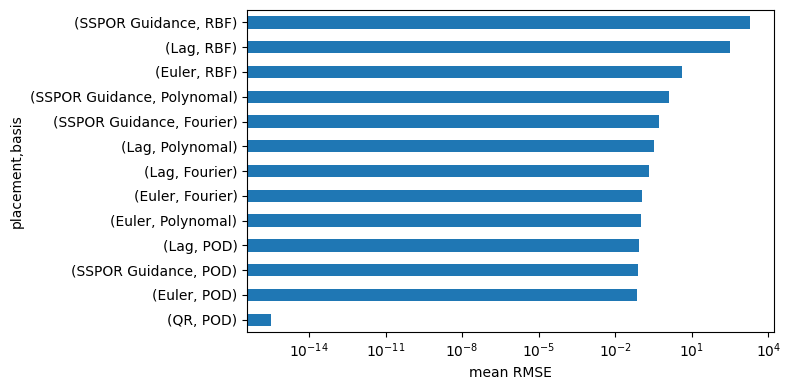

In [137]:
run_experiment()

QR              POD              0.034981 -- with noise (-7,7)
QR              POD          2.344194e-16 -- with noise (-3,3)
QR              POD          3.237642e-16 -- no noise